In [ ]:
import torch
from hippocampal_sensory_layers import (
    IterativeBidirectionalPseudoInverseHippocampalSensoryLayer,
)
from vectorhash import build_scaffold
from data_utils import load_mnist_dataset, prepare_data, determine_input_size
from smoothing import RatSLAMSmoothing
from graph_utils import plot_imgs_side_by_side
from matplotlib import pyplot as plt
import os

basedir='experiments/certainty_counting_h'
os.makedirs(basedir, exist_ok=True)
N_h = 400
device = "cuda"
sparsity = 0.01
expected_number_active = N_h * sparsity
scaffold, mean_h = build_scaffold(
    shapes=[(3, 3, 3), (4, 4, 4)],
    N_h=N_h,
    percent_nonzero_relu=sparsity,
    device=device,
    sparse_initialization=0.6,
    smoothing=RatSLAMSmoothing(device=device),
)
dataset = load_mnist_dataset()
input_size = determine_input_size(dataset)
obs, noisy_obs = prepare_data(dataset, scaffold.N_patts * 2, device=device)
layer = IterativeBidirectionalPseudoInverseHippocampalSensoryLayer(
    input_size, N_h, 1, epsilon_hs=0.1, epsilon_sh=0.1, device=device
)
noise_only = torch.randn(28, 28, device=device)
print(scaffold.relu_theta)
print(mean_h)

/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  400
2.080748794266975
0.0011676187828059507


/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [2]:
for i in range(scaffold.N_patts):
    layer.learn(scaffold.H[i], obs[i])

/home/ezrahuang/Projects/rl-research/vectorhash/hippocampal_sensory_layers.py:107: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  1 + input.T @ self.inhibition_matrix_hs @ input


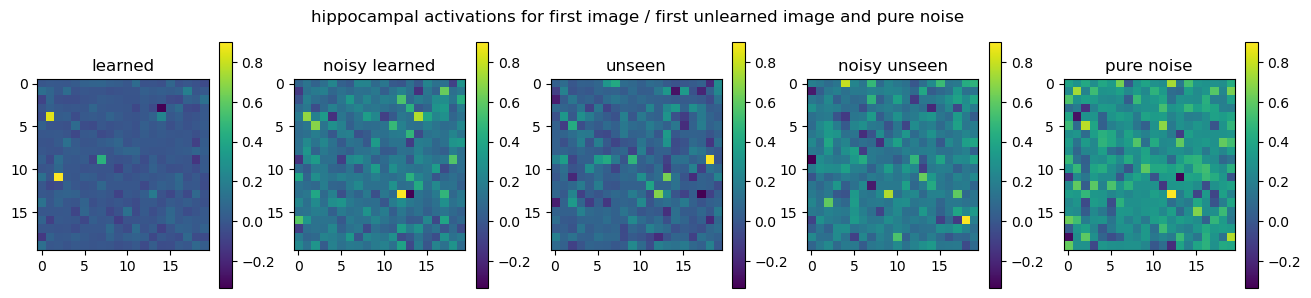

In [20]:
fig, axs = plt.subplots(ncols=5, figsize=(16, 3.2))
plot_imgs_side_by_side(
    imgs=[
        layer.hippocampal_from_sensory(img).cpu().reshape(20, 20)
        for img in [
            obs[0],
            noisy_obs[0],
            obs[scaffold.N_patts],
            noisy_obs[scaffold.N_patts],
            noise_only.flatten(),
        ]
    ],
    axs=axs,
    titles=["learned", "noisy learned", "unseen", "noisy unseen", "pure noise"],
    fig=fig,
)
fig.suptitle("hippocampal activations for first image / first unlearned image and pure noise")

fig.savefig(f"{basedir}/hip_cell_activations_emperical.png")

torch.Size([1728, 400])
torch.Size([1728, 400])
torch.Size([1728, 400])
torch.Size([1728, 400])
torch.Size([1, 400])


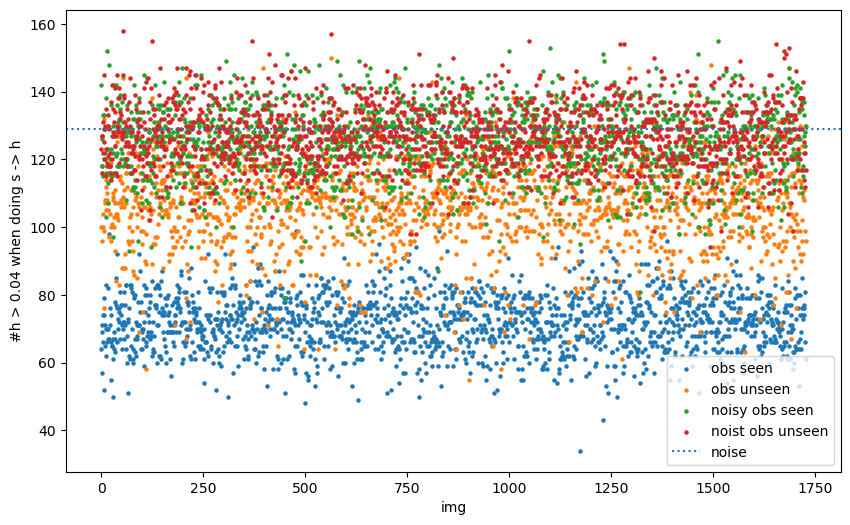

In [27]:
def sparsity(x, theta):
    print(x.shape)
    return torch.sum((x - theta > 0).int(), dim=1)


fig, ax = plt.subplots(figsize=(10, 6))

titles = [
    "obs seen",
    "obs unseen",
    "noisy obs seen",
    "noist obs unseen",
]
subsets = [
    obs[: scaffold.N_patts],
    obs[scaffold.N_patts : scaffold.N_patts * 2],
    noisy_obs[: scaffold.N_patts],
    noisy_obs[scaffold.N_patts : scaffold.N_patts * 2],
]


thresh = 0.04


def count(subset):
    return sparsity(layer.hippocampal_from_sensory(subset), thresh).cpu()
    # return sparsity(
    #     scaffold.hippocampal_from_grid(
    #         scaffold.denoise(
    #             scaffold.grid_from_hippocampal(layer.hippocampal_from_sensory(subset))
    #         )
    #     ),
    #     thresh,
    # ).cpu()


for title, subset in zip(titles, subsets):
    ax.scatter(
        torch.arange(scaffold.N_patts),
        count(subset),  # (Npatts x N_h)
        label=title,
        s=5
    )

ax.axhline(
    y=count(noise_only.flatten()),
    label="noise",
    linestyle=":",
)
# ax.axhline(
#     y=expected_number_active,
#     label="expected number active",
# )


ax.set_xlabel("img")
ax.set_ylabel(f"#h > {thresh} when doing s -> h")
ax.legend()

fig.savefig(f"{basedir}/h_count_scatter.png")

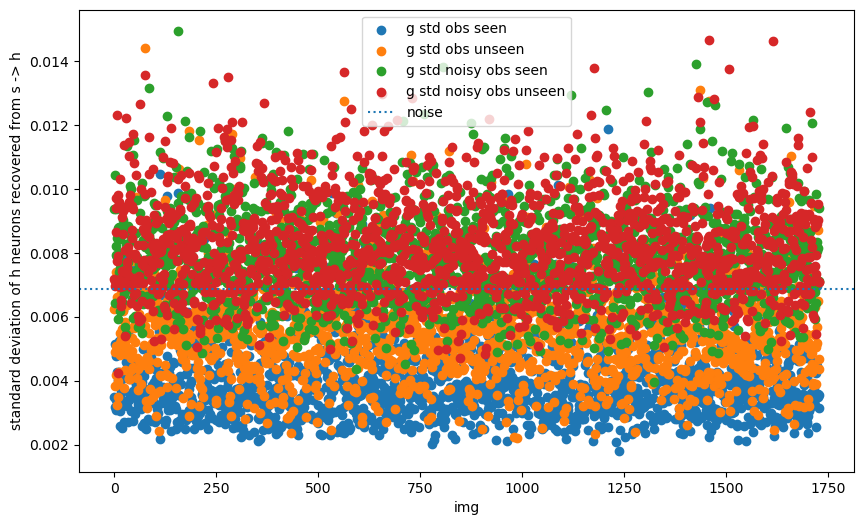

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    torch.arange(scaffold.N_patts),
    scaffold.grid_from_hippocampal(
        layer.hippocampal_from_sensory(obs[: scaffold.N_patts])
    )
    .cpu()
    .std(dim=1),
    label="g std obs seen",
)
ax.scatter(
    torch.arange(scaffold.N_patts),
    scaffold.grid_from_hippocampal(
        layer.hippocampal_from_sensory(obs[scaffold.N_patts : scaffold.N_patts * 2])
    )
    .cpu()
    .std(dim=1),
    label="g std obs unseen",
)
ax.scatter(
    torch.arange(scaffold.N_patts),
    scaffold.grid_from_hippocampal(
        layer.hippocampal_from_sensory(noisy_obs[: scaffold.N_patts])
    )
    .cpu()
    .std(dim=1),
    label="g std noisy obs seen",
)
ax.scatter(
    torch.arange(scaffold.N_patts),
    scaffold.grid_from_hippocampal(
        layer.hippocampal_from_sensory(
            noisy_obs[scaffold.N_patts : scaffold.N_patts * 2]
        )
    )
    .cpu()
    .std(dim=1),
    label="g std noisy obs unseen",
)
ax.axhline(
    y=scaffold.grid_from_hippocampal(
        layer.hippocampal_from_sensory(noise_only.flatten())
    )
    .cpu()
    .std(dim=1),
    label="noise",
    linestyle=":",
)

ax.set_xlabel("img")
ax.set_ylabel("standard deviation of h neurons recovered from s -> h")
ax.legend()